# MLP

K=4.  
Normalized K-mer counts.  
Two-layer MLP.  

## Environment setup

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-11-03 13:30:51.615843
Python 3.10.6
sklearn 1.1.2


In [2]:
import tensorflow as tf
dt = np.float32
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 
#from sklearn.model_selection import ShuffleSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import StratifiedKFold
#import tensorflow as tf
#from tensorflow import keras
#from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
#from keras.layers import Bidirectional
from keras.layers import Dense
#from keras.layers import LayerNormalization
#from sklearn.preprocessing import StandardScaler
from keras.losses import BinaryCrossentropy
from sklearn.model_selection import KFold

from KmerCounter import KmerCounter
ALPHABET_SIZE=4
K=4
counter=KmerCounter(K)
VOCABULARY_SIZE = counter.get_vocabulary_size() 
print('K=',K,'alphabet size=',ALPHABET_SIZE,'vocabulary size=',VOCABULARY_SIZE)
from TrainValidSplit2 import Splitter2
EPOCHS=10
FOLDS=5
from cell_lines import Cell_Lines
CELL_LINE_NUMBER = 0

K= 4 alphabet size= 4 vocabulary size= 256


In [3]:
DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'
GENES_FILE = 'CNRCI_coding_train_genes.csv'
RCI_FILE = 'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE='CNRCI_coding_train_counts.K4.gc42.csv'

In [4]:
# Consider a Cell_Lines object to represent today's cell line.
all_cell_lines = Cell_Lines.get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 0 = A549


## Model design

In [5]:
def build_model():
    # Here is the joke model -- one neuron!
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=VOCABULARY_SIZE)
    layer2 = Dense(8, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    print("...COMPILED")
    return mlp

In [6]:
# Model setup
print(datetime.now())
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once

2022-11-03 13:30:56.481602
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 8)                 520       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 16,977
Trainable params: 16,977
Non-trainable params: 0
_________________________________________________________________
None


## Load the data

In [7]:
print(datetime.now())
# labels
filepath = DATA_DIR+RCI_FILE
gene_to_rci = {}
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line = row.strip()
            fields = line.split(',')
            gene_id = fields[0]
            rci_val = fields[CELL_LINE_NUMBER+1]
            # Could implement Gudenas style threshold here
            if rci_val != "nan":
                gene_to_rci[gene_id] = float(rci_val)
print('Num RCI:', len(gene_to_rci.keys()))
print(list(gene_to_rci.items())[:3])
all_genes = list(gene_to_rci.keys())

2022-11-03 13:30:56.582978
Num RCI: 10338
[('ENSG00000000003', 1.08068), ('ENSG00000000419', 1.32679), ('ENSG00000000457', 0.434284)]


In [8]:
# kmer counts
print(datetime.now())
print('Read kmer counts file')
filepath = DATA_DIR+COUNTS_FILE
labels=[]
allids=[]
counts=[]
with open (filepath,'r') as handle:
    header = None
    for row in handle:
        if header is None:
            header = row
        else:
            line    = row.strip()
            fields  = line.split(',')
            gene_id = fields.pop(0)
            tran_id = fields.pop(0)
            numbers = [int(x) for x in fields]
            if gene_id in gene_to_rci.keys():
                rci_val = gene_to_rci[gene_id]
                allids.append( (gene_id,tran_id) )
                labels.append(rci_val)
                counts.append(numbers)
print(datetime.now())
print('Normalize')
rows = len(counts)
cols = len(counts[0])
for row in range(rows):
    total = sum(counts[row])
    for col in range(cols):
        counts[row][col] /= total
print(datetime.now())
print('Num IDs:',len(allids))
#print('Examples:',[allids[x] for x in [10, 20, 30, 40]] )
print('Num labels:',len(labels))
#print('Examples:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(counts))
#print('Example:',counts[3])

2022-11-03 13:30:56.623292
Read kmer counts file
2022-11-03 13:30:59.169021
Normalize
2022-11-03 13:31:00.818687
Num IDs: 54251
Num labels: 54251
Num counts: 54251


In [9]:
def get_gene_subset(all_genes,sub_index):
    sub_genes = set()
    for index in sub_index:
        one_gene = all_genes[index]
        sub_genes.add(one_gene)
    return sub_genes
def get_X_y(gene_set,allids,allX,allY,threshold):
    cnt = len(allids)
    subsetX=[]
    subsetY=[]
    if cnt != len(allX) or cnt!= len(allY):
        raise Exception('Lengths differ')
    for i in range(cnt):
        gene_id,tran_id = allids[i]
        if gene_id in gene_set:
            oneX = allX[i]
            oneY = allY[i]
            if oneY < threshold:
                Yvalue = int(0)
            else:
                Yvalue = int(1)
            subsetX.append(oneX)
            subsetY.append(Yvalue)
    return subsetX,subsetY

## Train and validate with all K-mer counts

In [10]:
SCALING = False
def do_cross_validation(eps):
    cv_scores = []
    fold=0
    print(datetime.now())
    print('splitting')
    # KFold shuffles once before making the partitions
    splitter = KFold(n_splits=FOLDS,shuffle=True,random_state=42)
    for train_index,valid_index in splitter.split(all_genes):
        train_genes = get_gene_subset(all_genes,train_index)
        valid_genes = get_gene_subset(all_genes,valid_index)
        X_train,y_train = get_X_y(train_genes,allids,counts,labels,0)
        X_valid,y_valid = get_X_y(valid_genes,allids,counts,labels,0)

        if SCALING:
            print('scaling')
            print(datetime.now())
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_valid = scaler.transform(X_valid)

        fold += 1
        print('Fold',fold)
        print('Train sizes',len(X_train),len(y_train))
        print('Valid sizes',len(X_valid),len(y_valid))
        print('Train set ones/size',
              np.count_nonzero(y_train),'/',len(y_train))
        print('Valid set ones/size',
              np.count_nonzero(y_valid),'/',len(y_valid))

        print("BUILD MODEL")
        model=build_model()

        print("FIT")
        print(datetime.now())
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                validation_data=(X_valid,y_valid) )

        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()

        print("Compute valiation accuracy")
        print(datetime.now())
        scores = model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print(datetime.now())
        cv_scores.append(scores[1] * 100)
    return cv_scores

2022-11-03 13:31:00.889176
2022-11-03 13:31:00.889176
splitting
Fold 1
Train sizes 43592 43592
Valid sizes 10659 10659
Train set ones/size 21682 / 43592
Valid set ones/size 5237 / 10659
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:31:00.937736
Epoch 1/10
1363/1363 [==============================] - 9s 7ms/step - loss: 0.6595 - accuracy: 0.6269 - val_loss: 0.6253 - val_accuracy: 0.6565
Epoch 2/10
1363/1363 [==============================] - 2s 1ms/step - loss: 0.6102 - accuracy: 0.6801 - val_loss: 0.6190 - val_accuracy: 0.6605
Epoch 3/10
1363/1363 [==============================] - 2s 1ms/step - loss: 0.6056 - accuracy: 0.6827 - val_loss: 0.6167 - val_accuracy: 0.6623
Epoch 4/10
1363/1363 [==============================] - 2s 1ms/step - loss: 0.6029 - accuracy: 0.6841 - val_loss: 0.6150 - val_accuracy: 0.6639
Epoch 5/10
1363/1363 [==============================] - 2s 1ms/step - loss: 0.6008 - accuracy: 0.6857 - val_loss: 0.6137 - val_accuracy: 0.6645
Epoch 6/10
1363/1363 [======

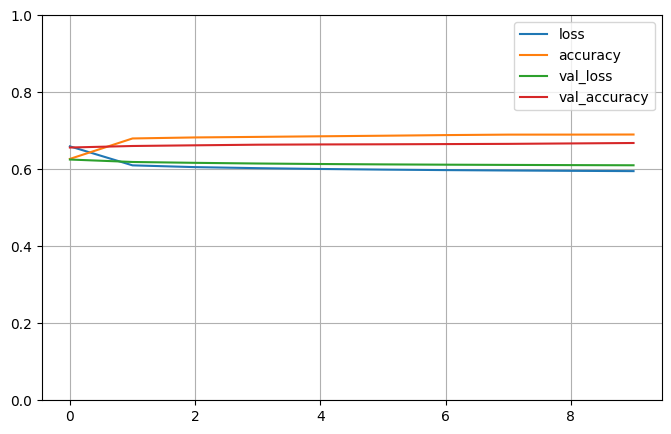

Compute valiation accuracy
2022-11-03 13:31:54.718707
accuracy: 66.83%
2022-11-03 13:32:02.274789
Fold 2
Train sizes 43443 43443
Valid sizes 10808 10808
Train set ones/size 21628 / 43443
Valid set ones/size 5291 / 10808
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:32:02.321657
Epoch 1/10
1358/1358 [==============================] - 10s 7ms/step - loss: 0.6649 - accuracy: 0.6260 - val_loss: 0.6251 - val_accuracy: 0.6751
Epoch 2/10
1358/1358 [==============================] - 2s 1ms/step - loss: 0.6123 - accuracy: 0.6761 - val_loss: 0.6161 - val_accuracy: 0.6776
Epoch 3/10
1358/1358 [==============================] - 2s 1ms/step - loss: 0.6071 - accuracy: 0.6795 - val_loss: 0.6138 - val_accuracy: 0.6779
Epoch 4/10
1358/1358 [==============================] - 2s 1ms/step - loss: 0.6039 - accuracy: 0.6808 - val_loss: 0.6121 - val_accuracy: 0.6780
Epoch 5/10
1358/1358 [==============================] - 2s 1ms/step - loss: 0.6015 - accuracy: 0.6825 - val_loss: 0.6110 - val_accuracy: 

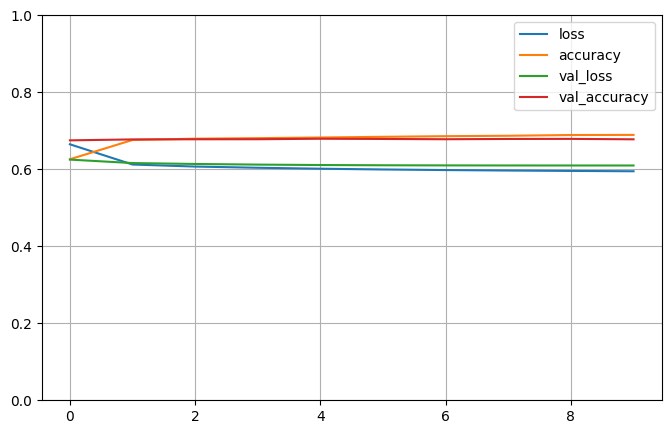

Compute valiation accuracy
2022-11-03 13:32:55.862327
accuracy: 67.78%
2022-11-03 13:33:03.412756
Fold 3
Train sizes 43240 43240
Valid sizes 11011 11011
Train set ones/size 21736 / 43240
Valid set ones/size 5183 / 11011
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:33:03.459646
Epoch 1/10
1352/1352 [==============================] - 10s 7ms/step - loss: 0.6694 - accuracy: 0.6129 - val_loss: 0.6283 - val_accuracy: 0.6810
Epoch 2/10
1352/1352 [==============================] - 2s 1ms/step - loss: 0.6132 - accuracy: 0.6771 - val_loss: 0.6124 - val_accuracy: 0.6781
Epoch 3/10
1352/1352 [==============================] - 2s 1ms/step - loss: 0.6070 - accuracy: 0.6795 - val_loss: 0.6099 - val_accuracy: 0.6811
Epoch 4/10
1352/1352 [==============================] - 2s 1ms/step - loss: 0.6043 - accuracy: 0.6809 - val_loss: 0.6082 - val_accuracy: 0.6801
Epoch 5/10
1352/1352 [==============================] - 2s 1ms/step - loss: 0.6022 - accuracy: 0.6828 - val_loss: 0.6069 - val_accuracy: 

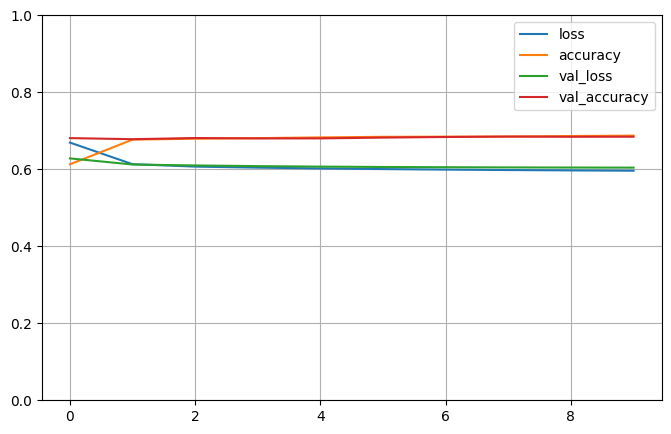

Compute valiation accuracy
2022-11-03 13:33:57.683882
accuracy: 68.46%
2022-11-03 13:34:05.311467
Fold 4
Train sizes 43345 43345
Valid sizes 10906 10906
Train set ones/size 21265 / 43345
Valid set ones/size 5654 / 10906
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:34:05.350130
Epoch 1/10
1355/1355 [==============================] - 10s 7ms/step - loss: 0.6714 - accuracy: 0.6085 - val_loss: 0.6268 - val_accuracy: 0.6716
Epoch 2/10
1355/1355 [==============================] - 2s 1ms/step - loss: 0.6141 - accuracy: 0.6777 - val_loss: 0.6056 - val_accuracy: 0.6746
Epoch 3/10
1355/1355 [==============================] - 2s 1ms/step - loss: 0.6085 - accuracy: 0.6795 - val_loss: 0.6021 - val_accuracy: 0.6805
Epoch 4/10
1355/1355 [==============================] - 2s 1ms/step - loss: 0.6061 - accuracy: 0.6804 - val_loss: 0.5994 - val_accuracy: 0.6827
Epoch 5/10
1355/1355 [==============================] - 2s 1ms/step - loss: 0.6042 - accuracy: 0.6809 - val_loss: 0.5973 - val_accuracy: 

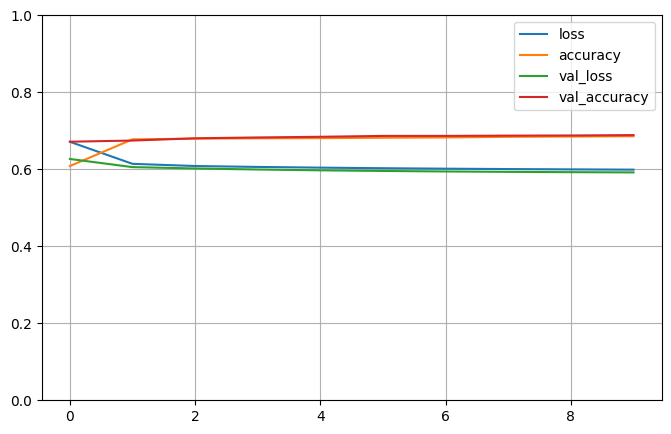

Compute valiation accuracy
2022-11-03 13:35:00.226649
accuracy: 68.88%
2022-11-03 13:35:07.462887
Fold 5
Train sizes 43384 43384
Valid sizes 10867 10867
Train set ones/size 21365 / 43384
Valid set ones/size 5554 / 10867
BUILD MODEL
COMPILE...
...COMPILED
FIT
2022-11-03 13:35:07.494151
Epoch 1/10
1356/1356 [==============================] - 9s 6ms/step - loss: 0.6700 - accuracy: 0.6042 - val_loss: 0.6163 - val_accuracy: 0.6927
Epoch 2/10
1356/1356 [==============================] - 1s 985us/step - loss: 0.6148 - accuracy: 0.6727 - val_loss: 0.5983 - val_accuracy: 0.6938
Epoch 3/10
1356/1356 [==============================] - 1s 985us/step - loss: 0.6100 - accuracy: 0.6748 - val_loss: 0.5956 - val_accuracy: 0.6960
Epoch 4/10
1356/1356 [==============================] - 1s 985us/step - loss: 0.6074 - accuracy: 0.6765 - val_loss: 0.5936 - val_accuracy: 0.6984
Epoch 5/10
1356/1356 [==============================] - 1s 973us/step - loss: 0.6052 - accuracy: 0.6769 - val_loss: 0.5921 - val_acc

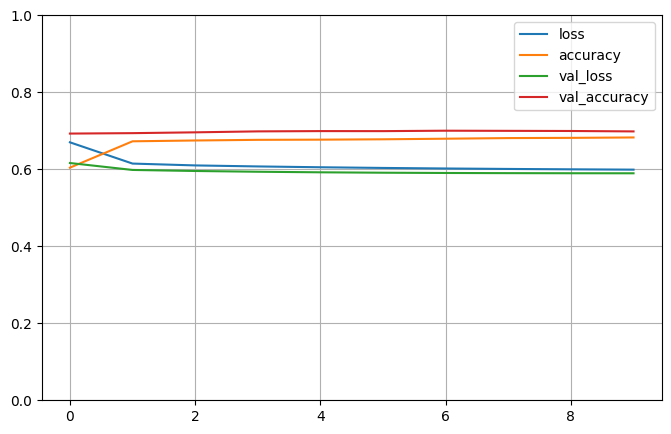

Compute valiation accuracy
2022-11-03 13:35:56.214523
accuracy: 69.84%
2022-11-03 13:36:03.419945
Cross validation acc mean 68.36% (+/- 1.01%)
2022-11-03 13:36:03.419945


In [11]:
print(datetime.now())
cv_scores = do_cross_validation(EPOCHS)    
print("Cross validation acc mean %.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))
print(datetime.now())